This project uses articles from TechCrunch from 2010 to 2016 to conduct Natural Languages Processing analysis.

### Import the Packages and Data

In [325]:
import pandas as pd
import numpy as np
import random
import re
import nltk
import pickle
from collections import Counter
from collections import OrderedDict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from tqdm import tqdm
%matplotlib inline

In [2]:
pd.options.display.max_columns = 100

### Import the data

In [3]:
raw = pd.read_csv('techcrunch_posts.csv')

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39115 entries, 0 to 39114
Data columns (total 11 columns):
authors     38815 non-null object
category    38393 non-null object
content     39061 non-null object
date        39115 non-null object
id          39115 non-null int64
img_src     39115 non-null object
section     39115 non-null object
tags        34148 non-null object
title       39115 non-null object
topics      5604 non-null object
url         39115 non-null object
dtypes: int64(1), object(10)
memory usage: 3.3+ MB


In [5]:
# Drop the articles without contents

df = raw[pd.notnull(raw['content'])]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39061 entries, 0 to 39114
Data columns (total 11 columns):
authors     38761 non-null object
category    38339 non-null object
content     39061 non-null object
date        39061 non-null object
id          39061 non-null int64
img_src     39061 non-null object
section     39061 non-null object
tags        34097 non-null object
title       39061 non-null object
topics      5590 non-null object
url         39061 non-null object
dtypes: int64(1), object(10)
memory usage: 3.6+ MB


In [10]:
# Fill null values

df[['category']].fillna('none', inplace = True)

//anaconda/lib/python3.5/site-packages/pandas/core/frame.py:2762: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


### Exploratory Data Analysis

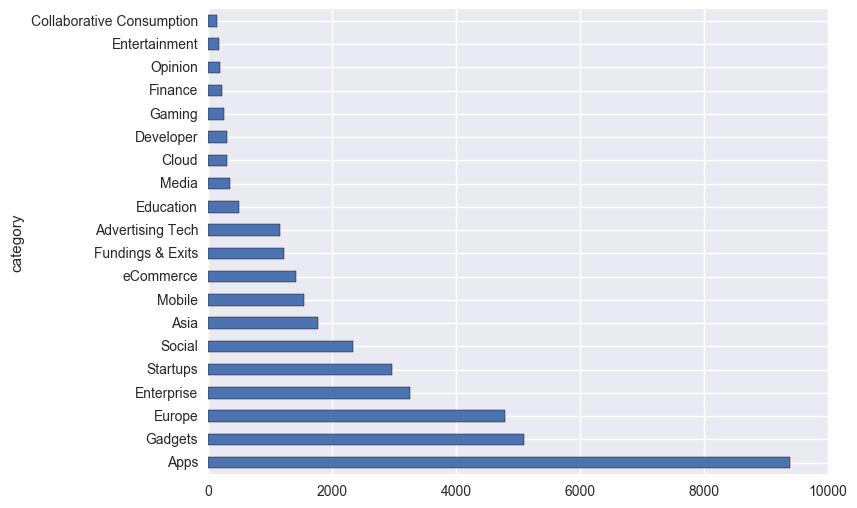

In [11]:
# Plot the categories

categories = df.groupby('category')['id'].count()
categories = categories.sort_values(ascending = False)[:20]

categories.plot(kind = 'barh', figsize=(8, 6))

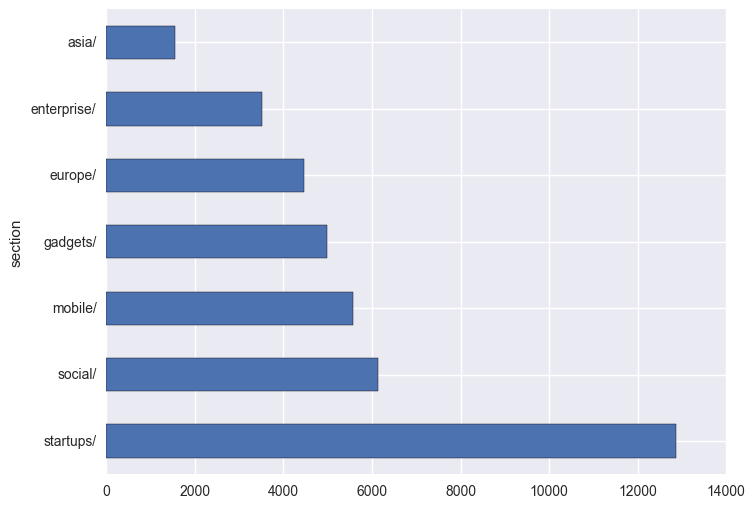

In [12]:
# Plot the sections

sections = df.groupby('section')['id'].count()
sections = sections.sort_values(ascending = False)[:20]

sections.plot(kind = 'barh', figsize=(8, 6))

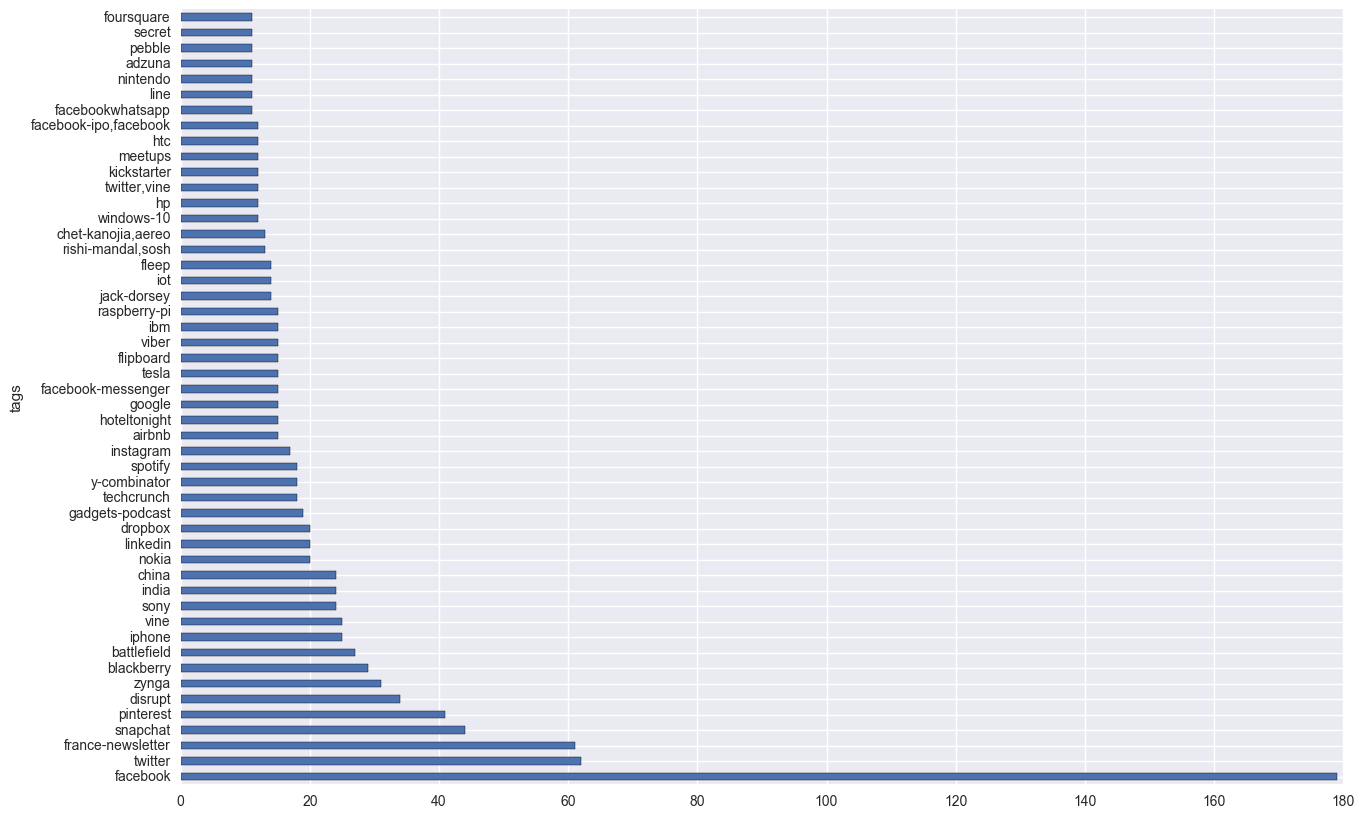

In [13]:
# Plot the tags

tags = df.groupby('tags')['id'].count()
tags = tags.sort_values(ascending = False)[:50]

tags.plot(kind = 'barh', figsize=(15, 10))

In [116]:
list_of_tags = []
for item in dict(tags[tags >= 15]).keys():
    list_of_tags.append(item)

In [117]:
len(list_of_tags)

31

### Document Processing

Create a dataframe with 15 documents from each of the top 31 tags.

In [118]:
# Only documents with top tags - 15 documents for each tag

def doc_with_tags(data, tags):
    dataframe = pd.DataFrame()
    for tag in tags:
        df_tag = df[df['tags'] == tag].sample(15)
        dataframe = dataframe.append(df_tag)
    return dataframe

In [119]:
df_tags = doc_with_tags(df, list_of_tags)

In [122]:
df_tags.head()

,authors,category,content,date,id,img_src,section,tags,title,topics,url
16320,Alex Williams,Enterprise,"The data center is what’s sexy, not the mobile...",2012-09-11,647383,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,disrupt,"Cloudera’s Kirk Dunn: The Data Center Is Sexy,...",NaN,https://techcrunch.com/2012/09/11/clouderas-ki...
16408,Ingrid Lunden,eCommerce,“… I wanted to be Bruce Lee. I wanted to be a ...,2012-09-10,645506,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,disrupt,“I Never Wanted To Be An Entrepreneur” Says Ja...,NaN,https://techcrunch.com/2012/09/10/i-never-want...
27113,Anthony Ha,eCommerce,Fab.com CEO Jason Goldberg took the stage toda...,2012-05-21,558107,https://tctechcrunch2011.files.wordpress.com/2...,social/,disrupt,"Fab.com Has 4.5M Members, CEO Wants To Work Wi...",NaN,https://techcrunch.com/2012/05/21/fab-ceo-jaso...
24852,Jordan Crook,Social,Jack Dorsey never wanted to be an entrepreneur...,2012-09-10,645640,https://tctechcrunch2011.files.wordpress.com/2...,social/,disrupt,"Jack Dorsey: “A Founder Is Not A Job, It’s A R...",NaN,https://techcrunch.com/2012/09/10/jack-dorsey-...
37070,Billy Gallagher,Startups,"PayTap, a shared social bill-payment platform,...",2012-09-10,644622,https://tctechcrunch2011.files.wordpress.com/2...,startups/,disrupt,Social Bill Payment Platform PayTap Goes Live ...,NaN,https://techcrunch.com/2012/09/10/social-bill-...


In [121]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465 entries, 16320 to 11818
Data columns (total 11 columns):
authors     464 non-null object
category    459 non-null object
content     465 non-null object
date        465 non-null object
id          465 non-null int64
img_src     465 non-null object
section     465 non-null object
tags        465 non-null object
title       465 non-null object
topics      84 non-null object
url         465 non-null object
dtypes: int64(1), object(10)
memory usage: 43.6+ KB


#### WordCloud

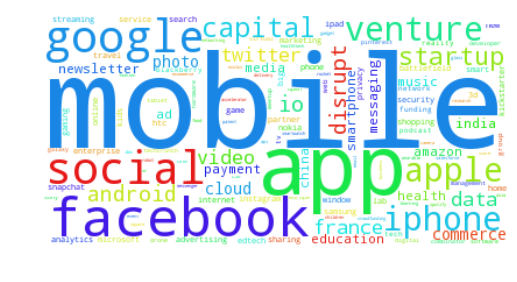

In [62]:
#Word Cloud for tags(without word size weights)

list_of_tags_combined = ' '.join([str(t) for t in df['tags']])
list_of_tags_combined = list_of_tags_combined.replace('nan', '')

cloud_text = list_of_tags_combined

wordcloud = WordCloud(stopwords=STOPWORDS, background_color = 'white').generate(cloud_text)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

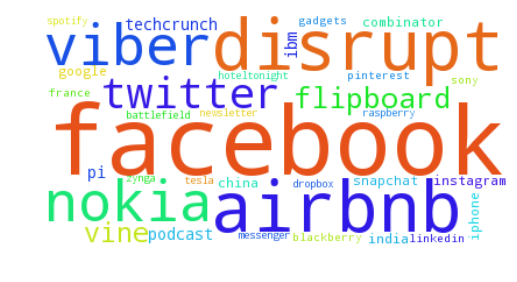

In [64]:
#Word Cloud for tags(without word size weights)
list_of_tags = [str(t) for t in df_tags['tags']]
list_of_tags_combined = ' '.join(list_of_tags)
list_of_tags_combined = list_of_tags_combined.replace('nan', '')

cloud_text = list_of_tags_combined

wordcloud = WordCloud(stopwords=STOPWORDS, background_color = 'white', font_path=).generate(cloud_text)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Process the article content by removing punctuation, convert words to lower case, remove stop words and stemming.

In [66]:
def process_content(data):
    
    # Keep only the words, remove punctuations
    formatted_content = re.sub("[^a-zA-Z]", " ", data)
    
    # Convert all words to lower case and split into a list
    words = formatted_content.lower().split()
    
    # List of stop words
    stop = stopwords.words('english')
    
    # Produce a list of clean words that does not appear in stop words
    clean_words = [w for w in words if w not in stop]
    
    # Stemming
    stemmer = nltk.stem.porter.PorterStemmer()
    stem_clean_words = [stemmer.stem(w) for w in clean_words if w not in stop]

    return " ".join(stem_clean_words)

In [21]:
# Create a list of clean contents, later uses pickle file


# complete_clean_content = []
# for article in df['content']:
#     startups_complete_clean_content.append(process_content(article))


In [22]:
# Save complete list of contents into pickle file

# pd.to_pickle(complete_clean_content, 'content.pkl')

In [23]:
# contents = pd.read_pickle('content.pkl')

In [148]:
# Create a list of clean contents for df_tags

def concat_tag_content(data, tag_list):
    total_list = []
    n = 0
    for tag in tag_list:
        print (str(n) + ' ' + tag)
        tags_clean_content = []
        sub_df = data[data['tags'] == tag]
        sub_list = []
        for article in sub_df['content']:
            sub_list.append(process_content(article))
        tags_clean_content.append(sub_list)
        words = [w for sublist in tags_clean_content for w in sublist]
        total_list.append(" ".join(words))
        n += 1
    return total_list

In [149]:
concat = concat_tag_content(df_tags, list_of_tags)

0 disrupt
1 facebook
2 airbnb
3 nokia
4 viber
5 twitter
6 y-combinator
7 vine
8 techcrunch
9 raspberry-pi
10 france-newsletter
11 google
12 instagram
13 iphone
14 china
15 facebook-messenger
16 spotify
17 pinterest
18 india
19 blackberry
20 sony
21 flipboard
22 linkedin
23 gadgets-podcast
24 snapchat
25 hoteltonight
26 dropbox
27 ibm
28 zynga
29 battlefield
30 tesla


In [150]:
concat

['data center sexi mobil devic kirk dunn cloudera say stage morn disrupt enterpris perspect true mani respect serv major theme panel discuss enterpris got sexi dunn aaron levi box todd mckinnon okta justin rosenstein come back respect innov dilemma said levi success compani world worth hundr billion dollar valu pretti much built legaci technolog technolog tradit run old school data center server run singl copi softwar today run elast network respond increas decreas demand infrastructur make app avail io android devic levi ad startup unfair advantag better posit use new modern infrastructur world ad differ distribut capabl sexi data center enabl capabl distribut million knowledg worker unit state billion devic world want bruce lee want sailor want tailor want craft product share other speak today techcrunch disrupt san francisco jack dorsey took audienc arriv today messag open futur chang evolut chang percept also good sign may necessarili abl predict might come next two compani help ov

In [151]:
len(concat)

31

In [153]:
contents = concat

#### Create a TD-IDF Matrix

In [246]:
# TF-IDF Matrix for top 1000 words, excluding words that appear in fewer than 5 articles and more than 90% of articles

tfidf = TfidfVectorizer(ngram_range=(1,1), min_df=5, max_df = 0.85, max_features=100, stop_words='english')
x_tfidf = tfidf.fit_transform(contents)

In [247]:
print('Matrix')
x_back_tfidf = x_tfidf.toarray()
print(x_back_tfidf)

Matrix
[[ 0.04737483  0.11905502  0.03260208 ...,  0.          0.01738148
   0.01855598]
 [ 0.03700833  0.15739061  0.00587726 ...,  0.00334513  0.02193383
   0.02341594]
 [ 0.06912473  0.0124081   0.05096761 ...,  0.64980177  0.03260745  0.        ]
 ..., 
 [ 0.          0.04539519  0.01864656 ...,  0.          0.08947106  0.        ]
 [ 0.01116801  0.01403285  0.01152828 ...,  0.02624601  0.01229238  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


In [248]:
pd.DataFrame(x_back_tfidf, columns=tfidf.get_feature_names())

,access,advertis,android,appl,becom,best,billion,blackberri,book,brand,buy,camera,ceo,china,citi,commun,connect,consum,content,countri,custom,data,desktop,devic,disrupt,dropbox,engin,event,everi,exampl,facebook,feed,follow,founder,friend,game,googl,growth,hotel,idea,imag,india,inform,instagram,invest,io,iphon,linkedin,list,messag,messeng,model,money,music,news,open,oper,percent,person,phone,photo,pin,pinterest,play,post,price,profil,public,quarter,rais,realli,report,revenu,run,sale,search,second,set,site,smartphon,snapchat,social,softwar,soni,spotifi,stori,team,tech,techcrunch,term,twitter,uber,updat,version,video,view,vine,watch,web,window
0,0.047375,0.119055,0.032602,0.055668,0.000000,0.031583,0.221083,0.000000,0.019843,0.143648,0.081505,0.000000,0.142124,0.000000,0.022036,0.034763,0.017956,0.032602,0.069526,0.019184,0.016830,0.067322,0.000000,0.100983,0.637941,0.096633,0.016301,0.000000,0.000000,0.084152,0.148448,0.045709,0.000000,0.230207,0.119055,0.125692,0.052144,0.000000,0.036094,0.197516,0.017381,0.000000,0.000000,0.025657,0.055668,0.031583,0.017381,0.030621,0.048903,0.018556,0.000000,0.017381,0.163010,0.044072,0.052144,0.050491,0.000000,0.000000,0.017381,0.063166,0.000000,0.000000,0.091863,0.000000,0.015792,0.081505,0.125692,0.032602,0.024657,0.089780,0.065204,0.000000,0.071824,0.094750,0.035912,0.034763,0.017381,0.031583,0.117813,0.000000,0.000000,0.191196,0.017956,0.000000,0.000000,0.092780,0.097806,0.114107,0.211914,0.033661,0.212647,0.000000,0.000000,0.000000,0.000000,0.016830,0.000000,0.000000,0.017381,0.018556
1,0.037008,0.157391,0.005877,0.013381,0.045549,0.008540,0.008540,0.000000,0.014308,0.016185,0.023509,0.003702,0.005694,0.000000,0.015890,0.009400,0.006474,0.017632,0.037601,0.062250,0.021238,0.048545,0.026834,0.009102,0.011500,0.000000,0.038202,0.009102,0.006474,0.024273,0.939983,0.078281,0.002939,0.000000,0.064387,0.077687,0.028201,0.020071,0.000000,0.006474,0.003133,0.011613,0.009400,0.009251,0.016726,0.019928,0.006267,0.000000,0.026448,0.010035,0.063874,0.003133,0.047018,0.000000,0.068935,0.045511,0.015667,0.051579,0.012534,0.002847,0.010035,0.000000,0.011040,0.009400,0.096791,0.008816,0.009711,0.014693,0.031115,0.006474,0.017632,0.025067,0.055028,0.014234,0.006474,0.018800,0.012534,0.008540,0.036409,0.007154,0.000000,0.103402,0.009711,0.000000,0.011613,0.040142,0.014693,0.014693,0.005877,0.009102,0.003833,0.000000,0.051242,0.020570,0.000000,0.069784,0.000000,0.003345,0.021934,0.023416
2,0.069125,0.012408,0.050968,0.324901,0.059250,0.157999,0.098750,0.000000,0.260570,0.011228,0.010194,0.000000,0.009875,0.000000,0.110239,0.217383,0.000000,0.081548,0.000000,0.035989,0.010525,0.042098,0.000000,0.031574,0.013297,0.000000,0.000000,0.042098,0.056142,0.168393,0.000000,0.000000,0.071355,0.035989,0.000000,0.000000,0.000000,0.058018,0.045141,0.101056,0.043477,0.000000,0.010869,0.000000,0.069622,0.049375,0.010869,0.000000,0.091742,0.197261,0.000000,0.032607,0.050968,0.000000,0.021738,0.021049,0.043477,0.042098,0.000000,0.019750,0.000000,0.000000,0.000000,0.000000,0.039500,0.010194,0.011228,0.040774,0.000000,0.078599,0.091742,0.032607,0.044914,0.019750,0.000000,0.000000,0.000000,0.019750,0.063147,0.000000,0.000000,0.000000,0.022457,0.000000,0.000000,0.011604,0.326193,0.040774,0.040774,0.063147,0.000000,0.139635,0.079000,0.010194,0.000000,0.000000,0.000000,0.649802,0.032607,0.000000
3,0.005962,0.000000,0.116924,0.056041,0.011923,0.011923,0.214616,0.013626,0.007491,0.094901,0.000000,0.162797,0.071539,0.055850,0.000000,0.006562,0.000000,0.036923,0.039371,0.007242,0.000000,0.000000,0.008028,0.298626,0.000000,0.000000,0.024616,0.012707,0.000000,0.000000,0.000000,0.017256,0.055385,0.000000,0.000000,0.040672,0.026247,0.049036,0.000000,0.013557,0.013124,0.000000,0.000000,0.000000,0.077057,0.035769,0.019685,0.000000,0.012308,0.000000,0.000000,0.019685,0.012308,0.058233,0.039371,0.000000,0.209977,0.038122,0.013124,0.470964,0.007005,0.000000,0.000000,0.026247,0.083462,0.123078,0.033893,0.006154,0.446802,0.000000,0.018462,0.17

#### PCA

In [302]:
# PCA using SVD - 20 components

pca_reducer_20 = PCA(n_components = 5, random_state= 4444)
pca_reduced_X_20 = pca_reducer_20.fit_transform(x_back_tfidf)

sum(pca_reducer_20.explained_variance_ratio_)

0.31251580863703443

In [260]:
# PCA using Truncated SVD - 20 components

reducer_svd_20 = TruncatedSVD(n_components = 20, random_state=4444)
reduced_X_svd_20 = reducer_svd_20.fit_transform(x_back_tfidf)

sum(reducer_svd_20.explained_variance_ratio_)

0.84203864290536912

#### Clustering - Kmeans

In [303]:
# K-means with truncated SVD - 20 components

num_clusters = 20

km = KMeans(n_clusters=num_clusters, random_state = 4444)

%time km.fit(pca_reduced_X_20)

clusters = km.labels_.tolist()

CPU times: user 77.9 ms, sys: 2.05 ms, total: 80 ms
Wall time: 44.3 ms


In [304]:
# RUN LATER

%time silhouette_score(pca_reduced_X_20, clusters)

CPU times: user 25.8 ms, sys: 4.67 ms, total: 30.4 ms
Wall time: 14.7 ms


0.21441045956809893

In [316]:
# Plot the Cluster vs Silhouetee

def plot_clusters(components, num_clusters, tfidf):
    plot_pca_reducer = PCA(n_components = components, random_state= 4444)
    plot_pca_reduced_X = plot_pca_reducer.fit_transform(tfidf)
    sil_list = []
    for n in list(range(2, num_clusters + 1)):
        num_clusters = n
        km = KMeans(n_clusters=num_clusters, random_state = 4444)
        km.fit(plot_pca_reduced_X)
        clusters = km.labels_.tolist()
        sil_list.append(silhouette_score(plot_pca_reduced_X, clusters))
    plt.plot(list(range(2, num_clusters + 1)), sil_list)
    plt.title('Silhouette Score vs Num of Clusters with ' + str(components) + ' Components')

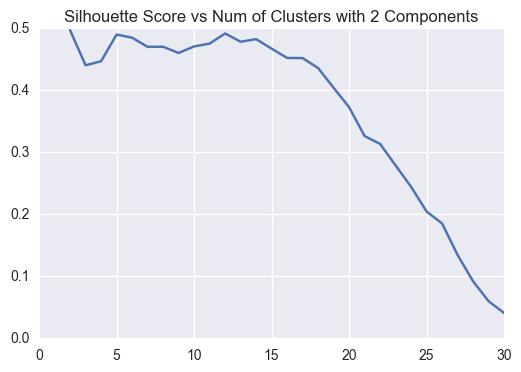

In [323]:
plot_clusters(2, 30, x_back_tfidf)

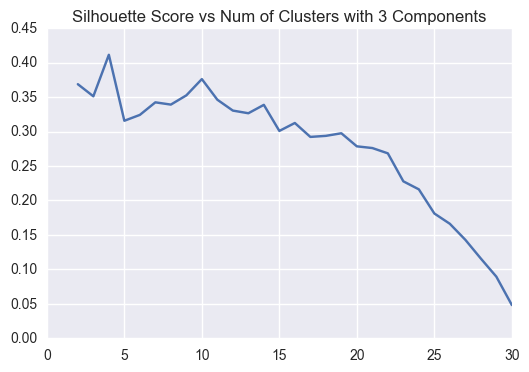

In [322]:
plot_clusters(3, 30, x_back_tfidf)

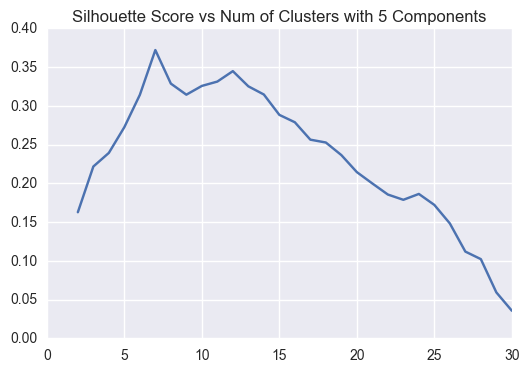

In [317]:
plot_clusters(5, 30, x_back_tfidf)

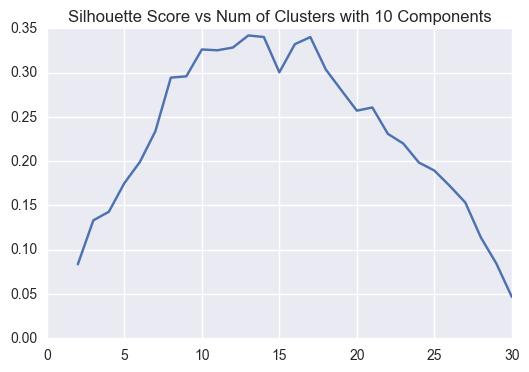

In [324]:
plot_clusters(10, 30, x_back_tfidf)

### Visualize the Data

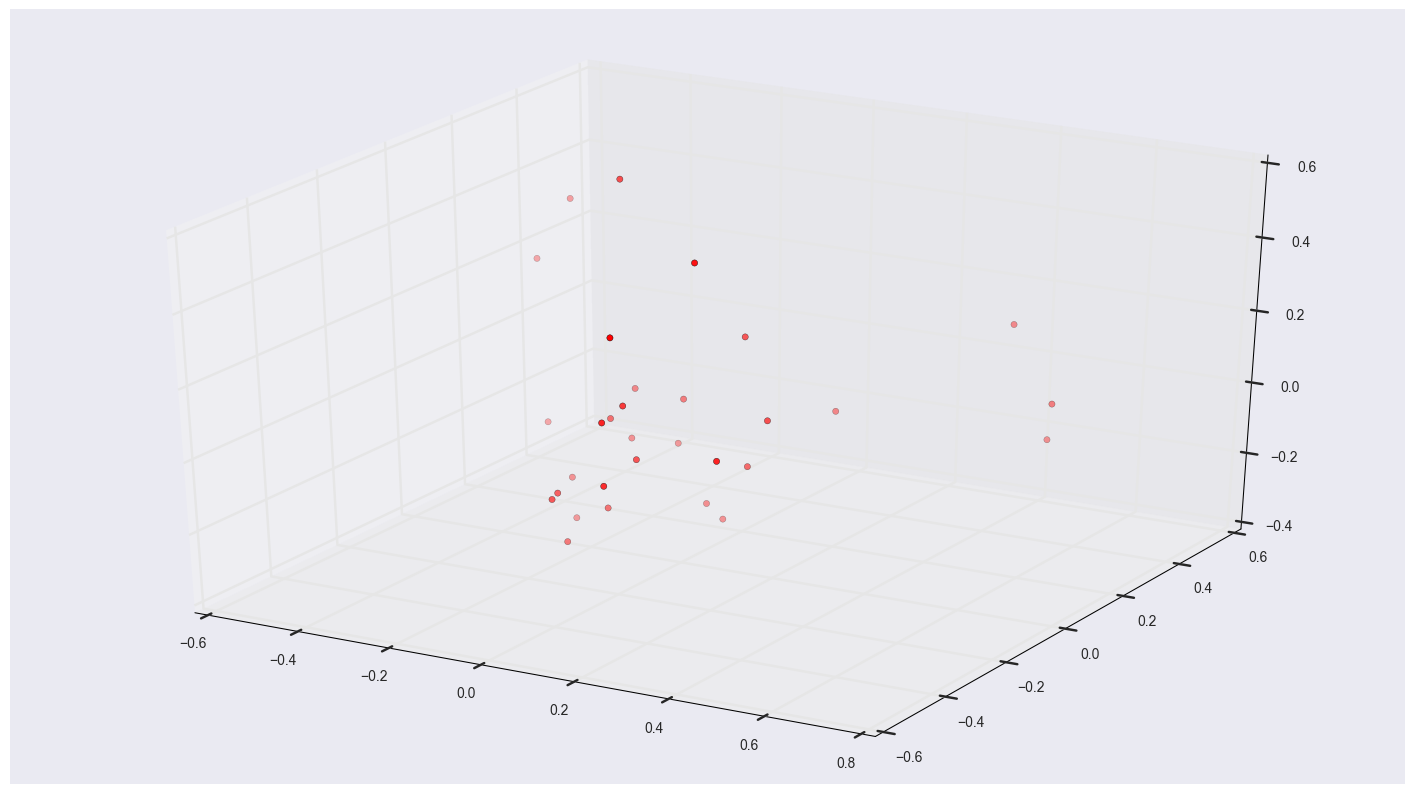

In [336]:
fig = plt.figure(figsize=(18, 10)) 
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pd.DataFrame(pca_reduced_X_3)[0], pd.DataFrame(pca_reduced_X_3)[1], pd.DataFrame(pca_reduced_X_3)[2], c='r')


plt.show()

In [339]:
pd.DataFrame(pca_reduced_X_3)

,0,1,2
0,0.385673,0.511877,0.118972
1,-0.507859,0.389930,0.345205
2,0.227580,-0.059276,0.055653
3,0.122570,-0.389311,0.394324
4,0.041039,-0.237562,0.132544
5,-0.177360,0.115220,-0.012026
6,0.175860,0.242630,-0.056584
7,-0.207268,-0.033341,-0.322888
8,0.522196,0.419233,-0.139301
9,0.301420,-0.329348,0.076451


In [326]:
# PCA using SVD - 3 components

pca_reducer_3 = PCA(n_components = 3, random_state= 4444)
pca_reduced_X_3 = pca_reducer_3.fit_transform(x_back_tfidf)


In [335]:
pd.DataFrame(pca_reduced_X_3)[0]

0     0.385673
1    -0.507859
2     0.227580
3     0.122570
4     0.041039
5    -0.177360
6     0.175860
7    -0.207268
8     0.522196
9     0.301420
10   -0.054990
11   -0.106975
12   -0.372788
13    0.084545
14    0.037564
15   -0.533155
16   -0.111664
17   -0.166543
18   -0.060645
19   -0.101046
20   -0.079378
21    0.100706
22   -0.120524
23    0.158252
24   -0.232009
25    0.051606
26    0.023591
27    0.146638
28   -0.210403
29    0.547073
30    0.116294
Name: 0, dtype: float64

In [35]:
# K-means with truncated SVD - 500 components

num_clusters = 10

km = KMeans(n_clusters=num_clusters)

%time km.fit(reduced_X_svd)

clusters = km.labels_.tolist()

CPU times: user 23.9 s, sys: 950 ms, total: 24.8 s
Wall time: 12.7 s


In [36]:
# RUN LATER 

Counter(clusters)

Counter({0: 1320,
         1: 3218,
         2: 10066,
         3: 7075,
         4: 3013,
         5: 2064,
         6: 6099,
         7: 3211,
         8: 1305,
         9: 1690})

In [ ]:
# RUN LATER

%time silhouette_score(pca_reduced_X, clusters)

In [86]:
%time silhouette_score(reduced_X_svd, clusters)

CPU times: user 525 ms, sys: 37.5 ms, total: 563 ms
Wall time: 311 ms


0.021424716694327633

#### Clustering - Agglomerative Hierarchical

In [77]:
num_cluster = 15

ah = AgglomerativeClustering(n_clusters = num_cluster, affinity = 'euclidean', linkage = 'ward')

%time ah.fit(reduced_X_svd)

clusters_ah = ah.labels_.tolist()

CPU times: user 2.59 s, sys: 23.4 ms, total: 2.61 s
Wall time: 2.62 s


In [78]:
# RUN LATER

Counter(clusters_ah)

Counter({0: 701,
         1: 1031,
         2: 254,
         3: 276,
         4: 130,
         5: 181,
         6: 26,
         7: 54,
         8: 65,
         9: 34,
         10: 80,
         11: 31,
         12: 63,
         13: 28,
         14: 13})

In [79]:
# RUN LATER

%time silhouette_score(pca_reduced_X, clusters_ah)

CPU times: user 679 ms, sys: 55.1 ms, total: 734 ms
Wall time: 413 ms


0.018402453915580722

In [80]:
# RUN LATER

%time silhouette_score(pca_reduced_X, clusters_ah)

CPU times: user 656 ms, sys: 40.3 ms, total: 697 ms
Wall time: 371 ms


0.018402453915580722

In [82]:
# Plot the number of cluster vs silhouette score

def plot_silouette(data, num):
    for n in range(num):
        print (n)

In [ ]:
plot_silouette(df, )

#### Clustering - DBSCAN

#### Topic Modeling - Create a Count Matrix

In [17]:
# Count Matrix for top 1000 words, excluding words that appear in fewer than 5 articles and more than 90% of articles

cv = CountVectorizer(ngram_range=(1,1), min_df=5, max_df = 0.9, max_features=1000, stop_words='english')

# Fit the vectorizer with article content
cv.fit(contents)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=1000, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [18]:
# Create the term-document matrix
# Transpose it so the terms are the rows

counts = cv.transform(contents).transpose()

In [ ]:
# Map matrix rows to words (tokens)

id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [ ]:
# Convert to gensim

corpus = matutils.Sparse2Corpus(counts)

In [19]:
print('Matrix')
x_back_cv = x_cv.toarray()
print(x_back_cv)

Matrix
[[0 0 0 ..., 0 0 0]
 [1 1 0 ..., 0 0 0]
 [2 1 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [20]:
pd.DataFrame(x_back_cv, columns=cv.get_feature_names()).head()

,abil,abl,acceler,accept,access,accord,account,achiev,acquir,acquisit,act,action,activ,actual,ad,add,addit,address,adopt,advanc,advantag,advertis,afford,age,agenc,aggreg,ago,ahead,aim,air,alert,algorithm,allow,alon,alreadi,altern,alway,amazon,america,american,analyt,android,angel,announc,anoth,answer,anyon,anyth,api,app,...,upgrad,upload,usag,use,user,usual,valley,valu,valuat,variou,vc,ventur,version,video,view,virtual,vision,visit,visual,voic,vr,wait,wall,want,watch,way,wearabl,web,websit,week,went,whatev,whatsapp,wide,wider,win,window,women,word,work,world,worth,write,wrote,yahoo,ye,year,york,young,youtub
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,2,0,0,5,4,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,7,0,0,0
2,2,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,2,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5,0,0,0
4,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0


#### Topic Modeling

#### Word2Vec

#### Recommender

Recommend articles with others that lay in the same cluster.

In [130]:
km.labels_[0]

17

In [132]:
# Function to return a list of article index that's in the same cluster

def rec_articles(index):  
    rec = []
    c = km.labels_[index]
    n = 0
    for item in km.labels_:
        if item == c:
            rec.append(n)
        n += 1
    return rec

In [138]:
rec_articles(1)

[1, 100, 649, 700, 745, 959, 962, 973]

#### Sentiment of each article

In [55]:
# Sentiment of articles

def article_sentiment(data):
    d = OrderedDict()
    n = 1
    article_sentiment = OrderedDict()
    for item in data:
        d[n] = TextBlob(item).sentiment
        n += 1
    return d

In [56]:
df_sentiments = article_sentiment(df['content'])

In [66]:
df_sentiments

OrderedDict([(1,
              Sentiment(polarity=0.1521342756570029, subjectivity=0.5428042874633782)),
             (2,
              Sentiment(polarity=0.11882332643202209, subjectivity=0.4306267253278124)),
             (3,
              Sentiment(polarity=0.12646656065023412, subjectivity=0.5562402450157552)),
             (4,
              Sentiment(polarity=0.10013408521303258, subjectivity=0.5248053467000836)),
             (5,
              Sentiment(polarity=0.10025974025974027, subjectivity=0.39515151515151514)),
             (6,
              Sentiment(polarity=0.21134580617339233, subjectivity=0.45092779187606774)),
             (7,
              Sentiment(polarity=0.08636898815470241, subjectivity=0.44738555095697946)),
             (8,
              Sentiment(polarity=0.1275573192239859, subjectivity=0.3000881834215167)),
             (9,
              Sentiment(polarity=0.08790711346266902, subjectivity=0.5865196942974722)),
             (10,
              Sentiment(pol

In [40]:
# Sentence tokennizer

sentences = sent_tokenize(raw['content'][0])

In [41]:
# Word tokenizer

tokenizer = TreebankWordTokenizer()
tokenizer.tokenize(sentences[0])

['Tech',
 'investing',
 'isn’t',
 'what',
 'it',
 'used',
 'to',
 'be',
 '—',
 'even',
 'compared',
 'to',
 'six',
 'months',
 'ago',
 '.']